In [1]:
import pickle
import torch
import argparse
import logging
from tensorboardX import SummaryWriter
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import glob
import natsort
import multiprocessing
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu, normaltest
from utils import *
from statannotations.Annotator import Annotator

In [2]:

with open('../test_dataset_results/ssims.pickle', 'rb') as f:
    ssims = pickle.load(f)
with open('../test_dataset_results/psnrs.pickle', 'rb') as f:
    psnrs = pickle.load(f)
with open('../test_dataset_results/gmsms.pickle', 'rb') as f:
    gmsms = pickle.load(f)
with open('../test_dataset_results/g_ssims.pickle', 'rb') as f:
    g_ssims = pickle.load(f)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bicubic vs. srcnn: Custom statistical test, P_val:6.650e-01
bicubic vs. srresnet: Custom statistical test, P_val:4.705e-01
bicubic vs. srgan: Custom statistical test, P_val:1.939e-01
bicubic vs. ddpm: Custom statistical test, P_val:4.705e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

bicubic vs. srcnn: Custom statistical test, P_val:6.650e-01
bicubic vs. srresnet: Custom statistical test, P_val:6.650e-01
bicubic vs. srgan: Custom statistical test, P_val:1.124e-01
bicubic vs. ddpm: Custom statistical test, P_val:4.705e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-0

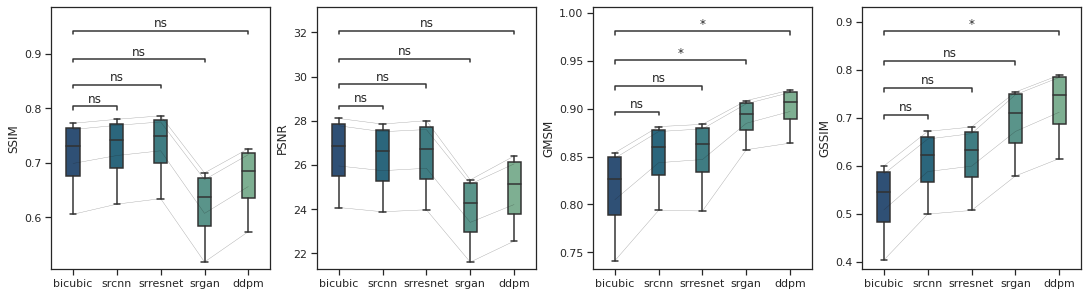

In [75]:
arrlist = [ssims,psnrs,gmsms,g_ssims]
metrics = ['SSIM','PSNR','GMSM','GSSIM']

dflist = []
for arr in arrlist:
    df = pd.DataFrame(arr)
    df.columns = ['C0004065','C0004214','C0004236','C0004238']
    df['labels'] = ['bicubic','srcnn','srresnet','srgan','ddpm']
    df = pd.melt(df, id_vars='labels', value_vars=['C0004065','C0004214','C0004236','C0004238'], value_name='value')
    dflist.append(df)

sns.set_theme(style="ticks")

f, ax = plt.subplots(1,4,figsize=(15, 4), constrained_layout=True)

i=0

for df in dflist:
    bicubic = df.loc[(df.labels == "bicubic"), "value"].values
    srcnn = df.loc[(df.labels == "srcnn"), "value"].values
    srresnet = df.loc[(df.labels == "srresnet"), "value"].values
    srgan = df.loc[(df.labels == "srgan"), "value"].values
    ddpm = df.loc[(df.labels == "ddpm"), "value"].values

    stat_results = [
      mannwhitneyu(bicubic, srcnn, alternative="two-sided"),
      mannwhitneyu(bicubic, srresnet, alternative="two-sided"),
      mannwhitneyu(bicubic, srgan, alternative="two-sided"),
      mannwhitneyu(bicubic, ddpm, alternative="two-sided"),
    ]

    pvalues = [result.pvalue for result in stat_results]

    # Plot with seaborn
    sns.lineplot(ax=ax[i], x="labels", y="value", hue="variable", palette=['k','k','k','k'], alpha=.4, linewidth=.4, legend=False, data=df)
        
    sns.boxplot(ax=ax[i], x="labels", y="value", data=df, whis=[0, 100], width=.3, palette="crest_r")
    
#     sns.barplot(ax=ax[i], x="labels", y="value", data=df, palette="vlag")
    
#     sns.stripplot(ax=ax[i], x="labels", y="value", data=df, size=4, color=".3", linewidth=0, jitter=False)
    
    pairs = [('bicubic', 'srcnn'),
             ('bicubic', 'srresnet'),
             ('bicubic', 'srgan'),
             ('bicubic', 'ddpm'),]

    annotator = Annotator(ax[i], pairs, x="labels", y="value", data=df, whis=[0, 100], width=.2, palette="crest_r")
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel(metrics[i])

    i+=1
    
plt.show()

In [56]:
avgs = []

for df in dflist:
    bicubic = df.loc[(df.labels == "bicubic"), "value"].values
    srcnn = df.loc[(df.labels == "srcnn"), "value"].values
    srresnet = df.loc[(df.labels == "srresnet"), "value"].values
    srgan = df.loc[(df.labels == "srgan"), "value"].values
    ddpm = df.loc[(df.labels == "ddpm"), "value"].values
    
    avgs.append([np.sum(bicubic)/4, np.sum(srcnn)/4, np.sum(srresnet)/4, np.sum(srgan)/4, np.sum(ddpm)/4])
    
avgs

In [ ]:
with open('../test_dataset_results/bvtv.pickle', 'rb') as f:
    bvtv = pickle.load(f)
with open('../test_dataset_results/tbth.pickle', 'rb') as f:
    tbth = pickle.load(f)
with open('../test_dataset_results/tbs.pickle', 'rb') as f:
    tbs = pickle.load(f)
with open('../test_dataset_results/tbn.pickle', 'rb') as f:
    tbn = pickle.load(f)

In [ ]:
arrlist = [bvtv, tbth, tbs , tbn]
metrics = ['BV/TV','TbTh','TbS','TbN']

dflist = []
for arr in arrlist:
    df = pd.DataFrame(arr)
    df.columns = ['C0004065','C0004214','C0004236','C0004238']
    df['labels'] = ['ground_truth','bicubic','srcnn','srresnet','srgan','ddpm']
    df = pd.melt(df, id_vars='labels', value_vars=['C0004065','C0004214','C0004236','C0004238'], value_name='value')
    dflist.append(df)

sns.set_theme(style="ticks")

f, ax = plt.subplots(1,4,figsize=(15, 4), constrained_layout=True)

i=0

for df in dflist:
    bicubic = df.loc[(df.labels == "bicubic"), "value"].values
    srcnn = df.loc[(df.labels == "srcnn"), "value"].values
    srresnet = df.loc[(df.labels == "srresnet"), "value"].values
    srgan = df.loc[(df.labels == "srgan"), "value"].values
    ddpm = df.loc[(df.labels == "ddpm"), "value"].values

    stat_results = [
      mannwhitneyu(bicubic, srcnn, alternative="two-sided"),
      mannwhitneyu(bicubic, srresnet, alternative="two-sided"),
      mannwhitneyu(bicubic, srgan, alternative="two-sided"),
      mannwhitneyu(bicubic, ddpm, alternative="two-sided"),
    ]

    pvalues = [result.pvalue for result in stat_results]

    # Plot with seaborn
    sns.lineplot(ax=ax[i], x="labels", y="value", hue="variable", palette=['k','k','k','k'], alpha=.4, linewidth=.4, legend=False, data=df)
        
    sns.boxplot(ax=ax[i], x="labels", y="value", data=df, whis=[0, 100], width=.3, palette="flare_r")
    
#     sns.barplot(ax=ax[i], x="labels", y="value", data=df, palette="vlag")
    
#     sns.stripplot(ax=ax[i], x="labels", y="value", data=df, size=4, color=".3", linewidth=0, jitter=False)
    
    pairs = [('bicubic', 'srcnn'),
             ('bicubic', 'srresnet'),
             ('bicubic', 'srgan'),
             ('bicubic', 'ddpm'),]

    annotator = Annotator(ax[i], pairs, x="labels", y="value", data=df, whis=[0, 100], width=.2, palette="flare_r")
    annotator.set_pvalues(pvalues)
    annotator.annotate()
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel(metrics[i])

    i+=1
    
plt.show()